<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-первой-главе" data-toc-modified-id="Вывод-по-первой-главе-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по первой главе</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-второй-главе" data-toc-modified-id="Вывод-по-второй-главе-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по второй главе</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Вывод-по-третьей-главе" data-toc-modified-id="Вывод-по-третьей-главе-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод по третьей главе</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Дополнение-ко-главе" data-toc-modified-id="Дополнение-ко-главе-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Дополнение ко главе</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from catboost import Pool
warnings.filterwarnings('ignore')

In [ ]:
taxi_df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
taxi_df.sort_index(inplace = True)
taxi_df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Рассмотрим таблицу. Для этого скачаем ее, изменим тип данных Datetime с object на datetime64, установим индекс таблицы равным столбцу Datetime с помощью index_col() и parse_dates()

In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
report = taxi_df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] /taxi_df.shape[0]).round(2)
print (report.sort_values(by = 'missing_values', ascending = False))

            missing_values  % of total
num_orders               0         0.0


Рассмотрим общую информацию по таблице. В таблице у нас будет один столбец с количеством заказов, с 1 марта 2018 до 31 августа 2018

In [ ]:
taxi_df.index.is_monotonic

True

Проверим временную последовательность распределения данных. Данные последовательны. Далее сделаем ресемплирование данных, в первую очередь разобьем на интервал по часам(так как нам надо прогнозировать согласно проекту на будущие часы) 


Upd: первоначально разбил данные по дням, рмсе просто защкаливал, значение было выше 270 на всех использованных моделях, хотел бы уточнить, почему так произошло, ведь данные у нас одинаковые  

### Вывод по первой главе 

Мы загрузили датасет с количеством заказов такси, изменили тип данных для времени, проверили за какой период времени у нас есть данные, проверили данные на отсутствие пропусков. В дальнейшем ресемплируем данные по часам, сравним разные дни для определения взаимосвязи между днем недели, месяцем, временем суток и количеством заказов

## Анализ

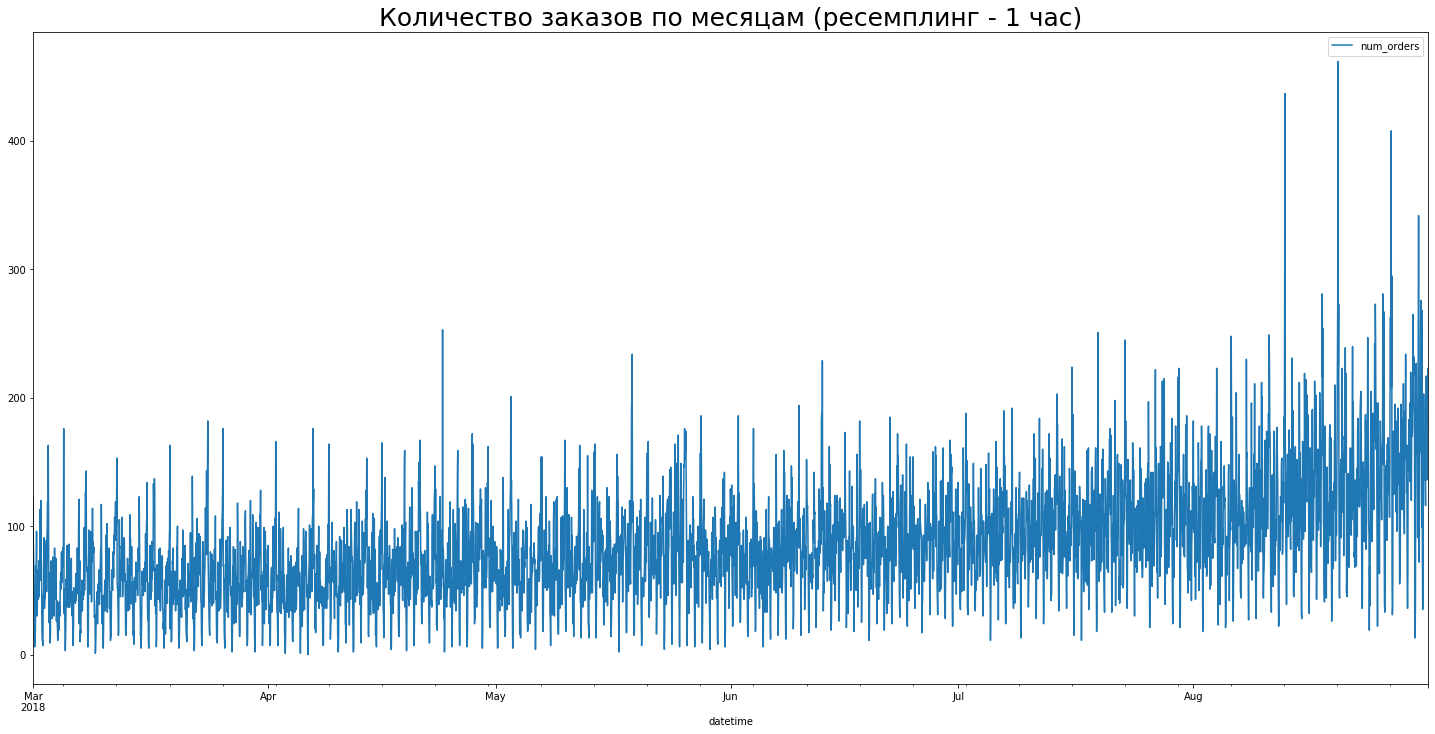

In [ ]:
taxi_df = taxi_df.resample('1H').sum()
figsize = (25,12)
taxi_df.plot(figsize=figsize)
plt.title('Количество заказов по месяцам (ресемплинг - 1 час)', fontsize = 25)
plt.show()

In [ ]:
decomposed = seasonal_decompose(taxi_df)

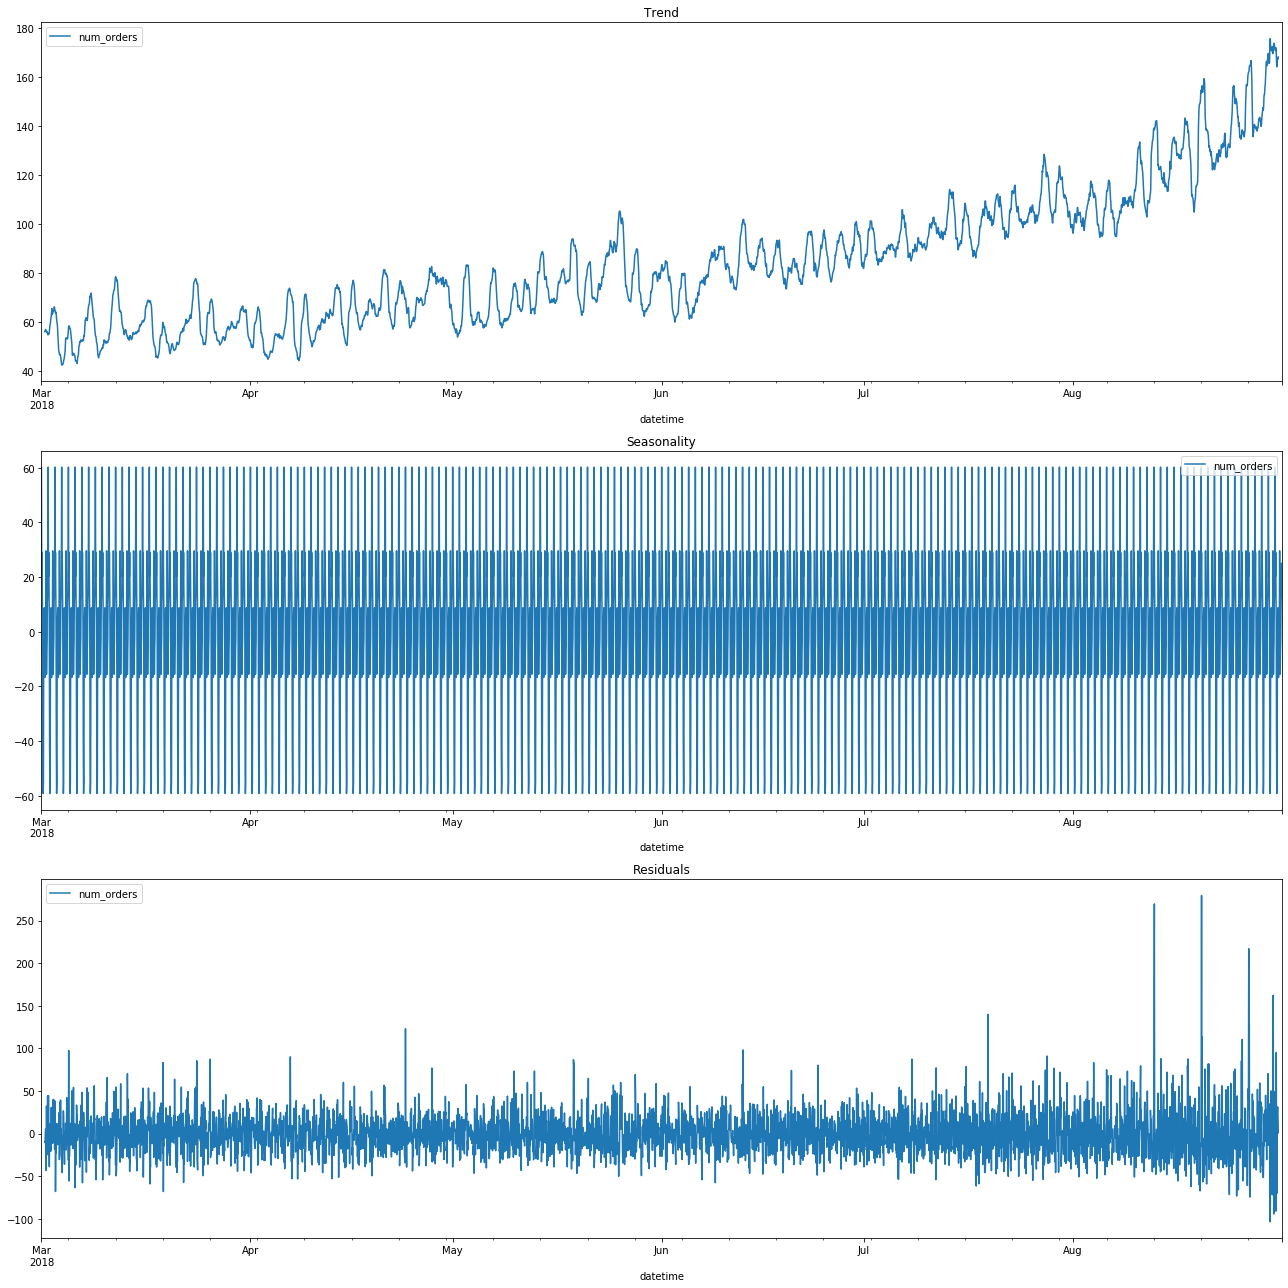

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Пока общая картина дает нам мало понимания, в каком количестве именно происходят заказы, мы видим, что иногда количество приближается к 0, иногда возрастает до 400. Пока единственная теория - количество заказов по мере приближению к лету увеличивается. Проверим эту теорию, в первую очередь выберем интервал в месяц

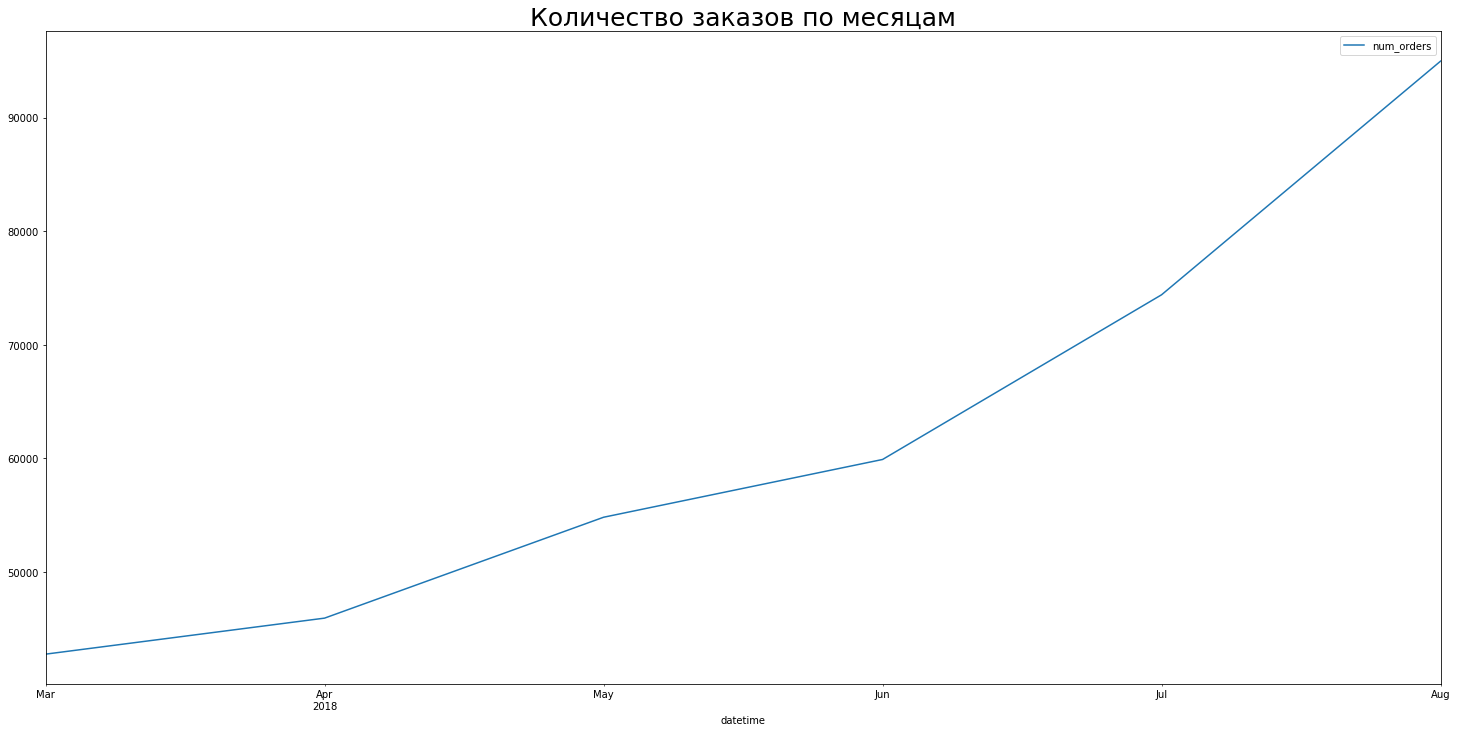

In [ ]:
taxi_df_month = taxi_df.resample('1M').sum()
figsize = (25,12)
taxi_df_month.plot(figsize=figsize)
plt.title('Количество заказов по месяцам', fontsize = 25)
plt.show()

Действительно, мы видим что количество вызовов увеличивается ближе к лету, серьезный скачок происходит в июне. Далее проверим, как меняется количество вызовов по дням недели, для этого возьмем две выборки, в апреле (c 2 по 8 апреля) и в июне (с 4 по 10 июня)

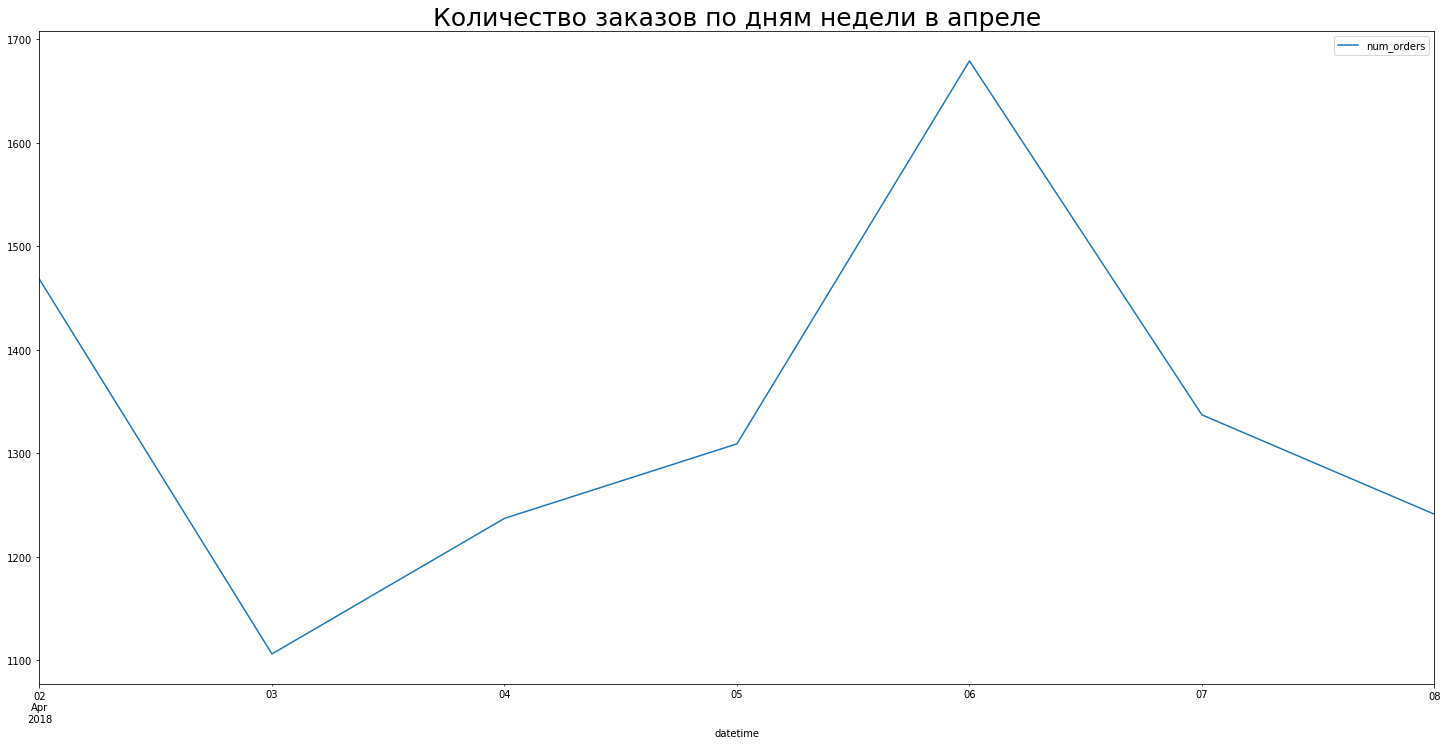

In [ ]:
taxi_april = taxi_df['2018-04-02':'2018-04-08']
taxi_april = taxi_april.resample('1D').sum()
taxi_april.plot(figsize=figsize)
plt.title('Количество заказов по дням недели в апреле', fontsize = 25)
plt.show()

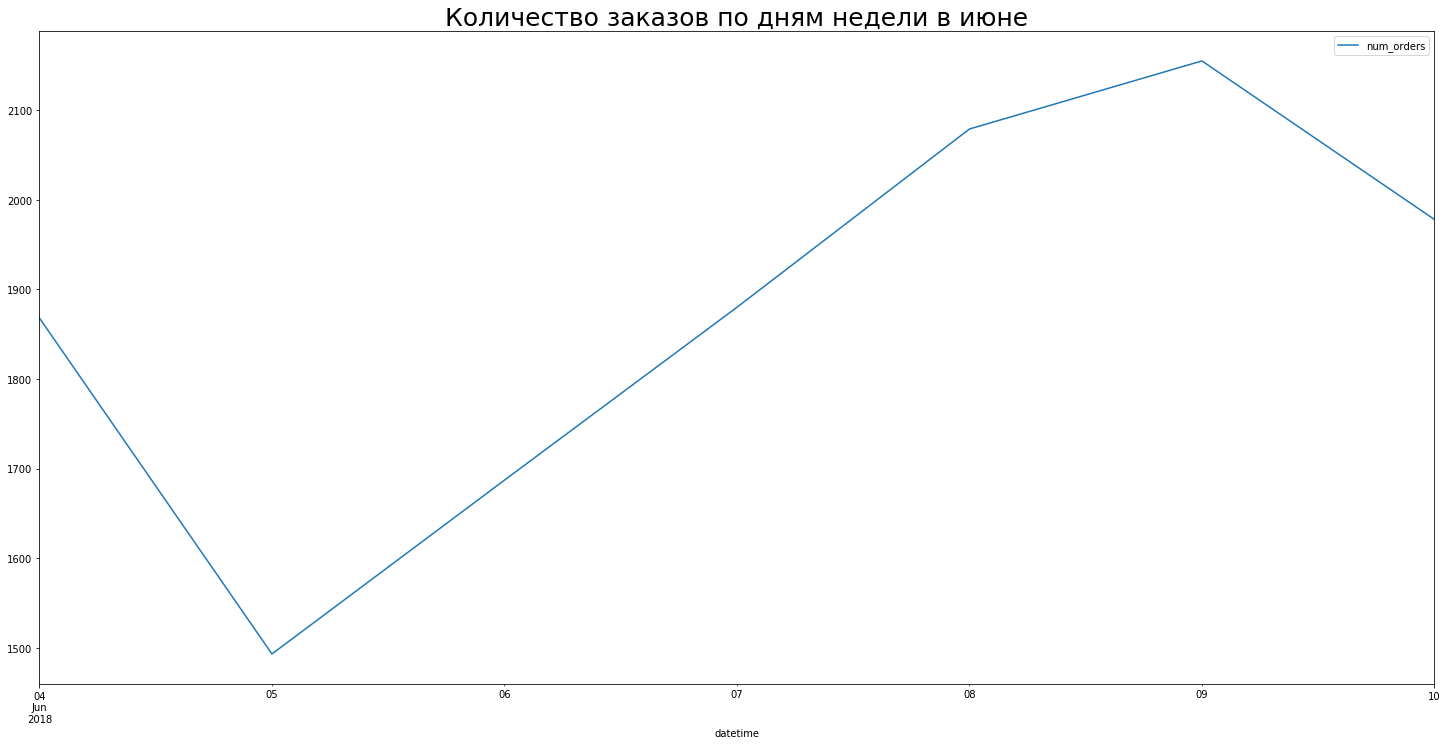

In [ ]:
taxi_june = taxi_df['2018-06-04':'2018-06-10']
taxi_june = taxi_june.resample('1D').sum()
taxi_june.plot(figsize = figsize)
plt.title('Количество заказов по дням недели в июне', fontsize = 25)
plt.show()

Мы видим, что есть некоторые сходства на двух графиках - меньше всего заказов происходит во вторник, максимум заказов приходится на конец недели: пятницу (в апреле) и субботу (в июне)

Далее рассмотрим на количество заказов в рамке одной недели и одного дня по часам, проверим есть ли зависимость между количеством заказов днем и ночью, испозуем те же выборки

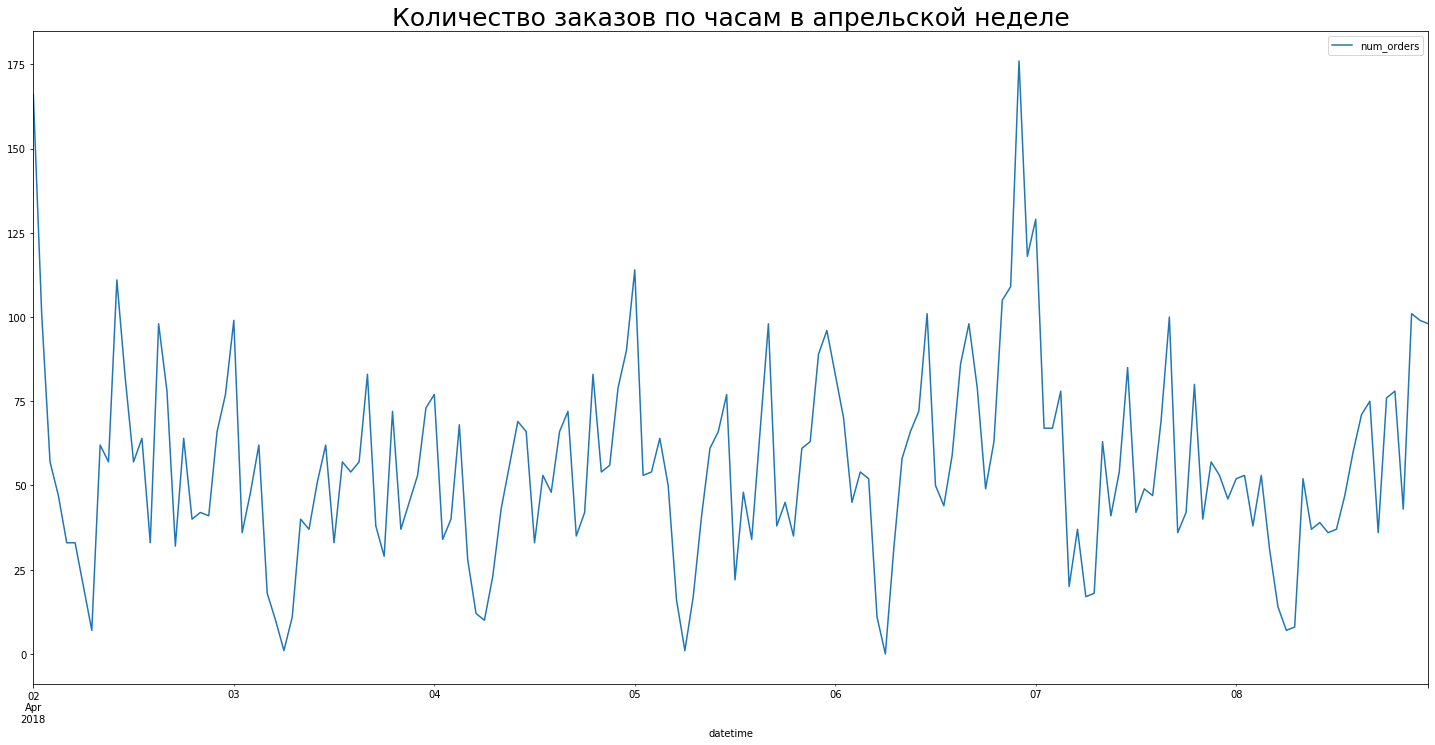

In [ ]:
taxi_df['2018-04-02':'2018-04-08'].plot(figsize=figsize)
plt.title('Количество заказов по часам в апрельской неделе', fontsize = 25)
plt.show()

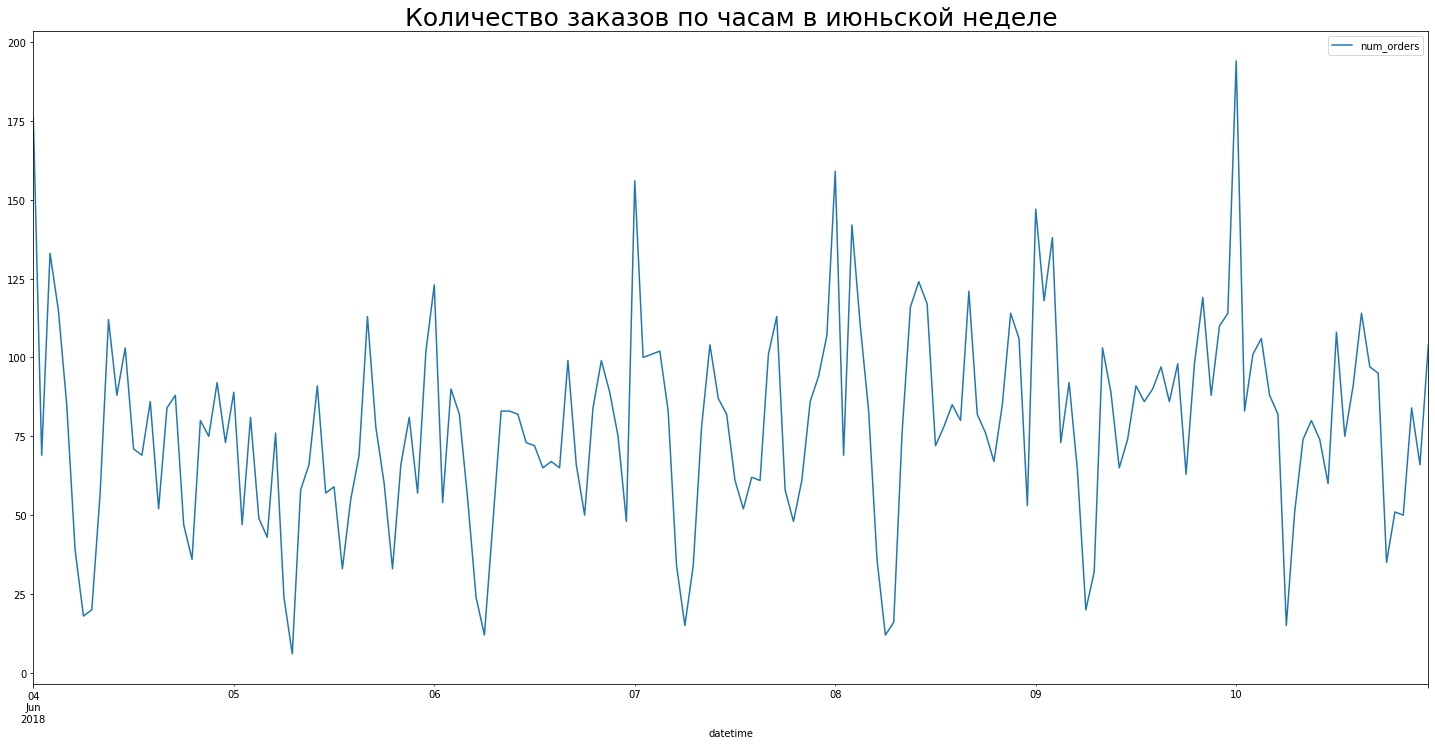

In [ ]:
taxi_df['2018-06-04':'2018-06-10'].plot(figsize=figsize)
plt.title('Количество заказов по часам в июньской неделе', fontsize = 25)
plt.show()

Мы видим, что количество заказов резко уменьшается ближе к 2 часам ночи (детальнее проверим далее), самые высокие показатели ближе к полуночи

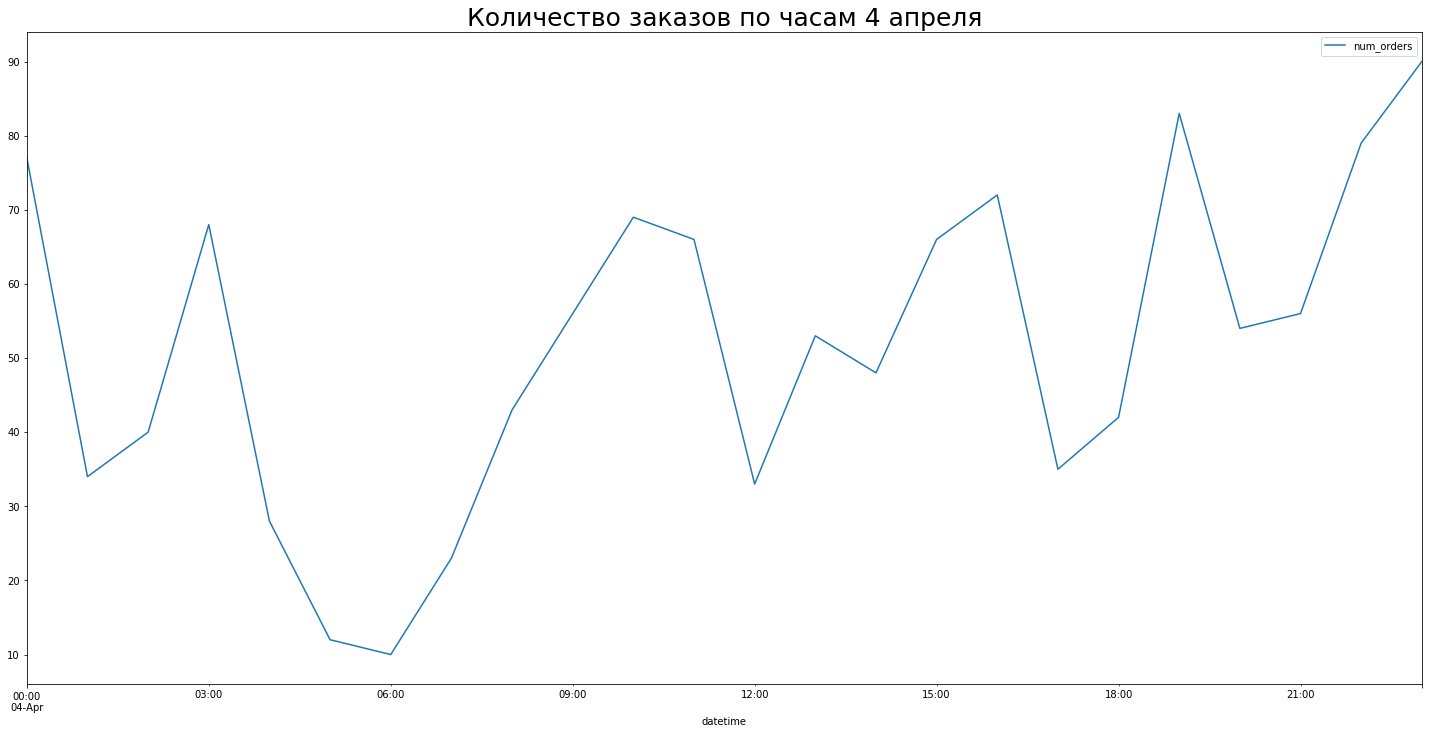

In [ ]:
taxi_df['2018-04-04'].plot(figsize=figsize)
plt.title('Количество заказов по часам 4 апреля', fontsize = 25)
plt.show()

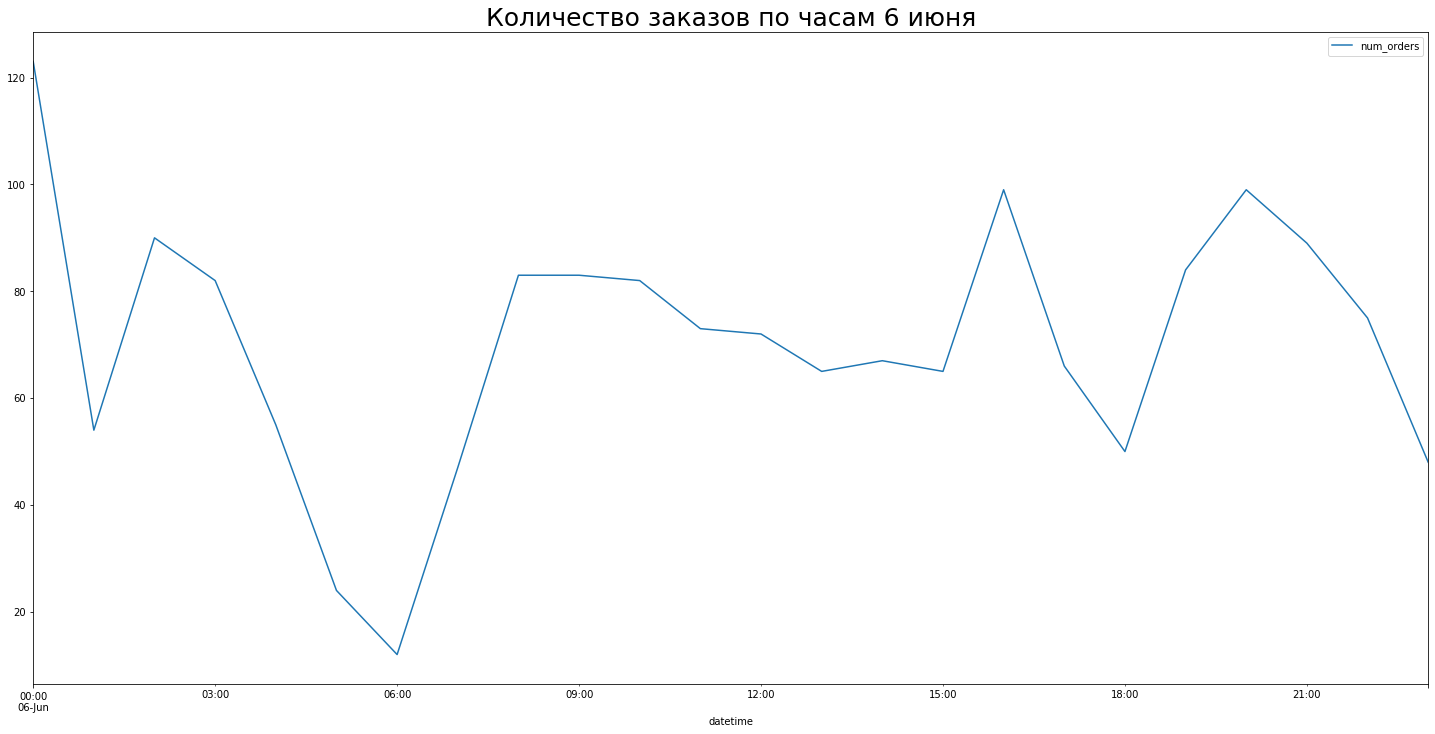

In [ ]:
taxi_df['2018-06-06'].plot(figsize=figsize)
plt.title('Количество заказов по часам 6 июня', fontsize = 25)
plt.show()

В целом ситуация с заказами по часам похожа как 4 апреля так и 6 июня. Количество заказов после 12 ночи со своего пика постепенно идут на убыль, а затем резко повышается к 3 часам ночи. Возможная причина - после часа ночи метро не работает, а люди едут после "ночных гуляний". Уровень заказов уменьшается к 6 вечера и увеличивается к утреннему времени, когда необходимо ехать на работу. Следующий резкий скачок присходит в 4 вечера, возможно с работы возвращается утренняя смена, после 6 вечера, в конце рабоего дня. Единственное отличие между месяцами - это окончание дня, в апреле количество заказов увеличивается к 12 часам ночи, в июне наоборот идет на спад. Возможно тут играет фактор времени года, и теплая июньская работа способствует прогулкам на воздухе.    


Вычислим скользящее среднее и добавим его как признак 'rolling_mean'. В функцию make_features() добавим новый аргумент rolling_mean_size, который задаст ширину окна.

In [ ]:
def make_features(taxi_df, max_lag, rolling_mean_size):
    taxi_df['dayofweek'] = taxi_df.index.dayofweek
    taxi_df['hour'] = taxi_df.index.hour
    for lag in range(1, max_lag + 1):
        taxi_df['lag_{}'.format(lag)] = taxi_df['num_orders'].shift(lag)
        taxi_df['rolling_mean'] = taxi_df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(taxi_df, 2, 24)
print(taxi_df.head(5))

                     num_orders  dayofweek  hour  lag_1  rolling_mean  lag_2
datetime                                                                    
2018-03-01 00:00:00         124          3     0    NaN           NaN    NaN
2018-03-01 01:00:00          85          3     1  124.0           NaN    NaN
2018-03-01 02:00:00          71          3     2   85.0           NaN  124.0
2018-03-01 03:00:00          66          3     3   71.0           NaN   85.0
2018-03-01 04:00:00          43          3     4   66.0           NaN   71.0


### Вывод по второй главе 

В данной главе мы ресемплировали данные, сравнили различные временные отрезки и нашли важные моменты:
1) Количество заказов возрастает ближе к летнему периоду, люди чаще могут позволить себе отдохнуть летом

2) По дням недели - меньше всего заказов происходит во вторник, максимум заказов приходится на конец недели

3) В целом в течение дня происходит одинаковая ситуация - пики заказов приходятся на 12 часов ночи(все едут домой после походов в ресторан), 3 часа ночи (метро уже закрыто), 7 часов утра(начало рабочего дня, также берем в рассчет что пробки в городе начинаются примерно в это время), 16 часов дня(возвращение домой работающих в утреннюю смену) и 18 часов дня(конец рабочего дня)

4) Добавили такие параметры как календарный день, день недели, месяц, час и нашли скользящее среднее. Год у нас один и тот же, его решил не добавлять

5) Подготовили данные для дальнейшего обучения

## Обучение

Разобьем на тестовую и тренировочную выборки, удалим пропуски в обучающей части. Сделаем тестовую выборку размером 10% от исходных данных

In [ ]:
train, test = train_test_split(taxi_df, shuffle = False, test_size = 0.2)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis = 1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis = 1)

### RandomForestRegressor

Для обучения используем 3 модели RandomForestRegressor, LGBMRegressor, Catboost. Воспользуемся Grid Search, однако к нему добавим TimeSeriesSplit, которое позволит нам оценивать наши модели для данных временных рядов по «будущим» наблюдениям. В конце для получения RMSE, домножим наш результат на -1 и найдем корень.

In [ ]:
%%time
regr = RandomForestRegressor()
parametrs = {'n_estimators': range (10, 51, 10),
              'max_depth': range (1,10,2),
              'random_state':[48]}
tscv = TimeSeriesSplit(n_splits = 8)
reg1 = GridSearchCV(regr, parametrs, cv = tscv, scoring = 'neg_mean_squared_error')
reg1.fit(features_train, target_train)
reg1pred = reg1.predict(features_train)
fina = (reg1.best_score_* -1) ** 0.5
print(fina)

23.594531498957725
CPU times: user 20.8 s, sys: 196 ms, total: 21 s
Wall time: 21.6 s


Внес изменения в n_splits, теперь понял зависимость между размерами выборки и n_splits, установил везде "8"

Ниже выведем параметры, которые определил gs

In [ ]:
reg1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=48, verbose=0,
                      warm_start=False)

### LGBMRegressor

In [ ]:
%%time
warnings.simplefilter(action = 'ignore', category = FutureWarning)
modelLight1 = LGBMRegressor(loss_function='RMSE', n_jobs = -1)
tscv = TimeSeriesSplit(n_splits = 8)
parameters_light = {'depth': range (1,8,2), 'learning_rate':[0.2], 'num_leaves':[16,24]}
light = GridSearchCV(modelLight1, parameters_light,
            cv = tscv,
            verbose = True)
light.fit(features_train, target_train)
light.predict(features_train)
light.best_estimator_

Fitting 8 folds for each of 8 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   44.9s finished


CPU times: user 44.3 s, sys: 660 ms, total: 45 s
Wall time: 45.5 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=1, importance_type='split', learning_rate=0.2,
              loss_function='RMSE', max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=16, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

### Catboost

Для Catboost создадим датасет Pool, по аналогии с предыдущим проектом, метрику для поиска установим RMSE

In [ ]:
train_dataset = Pool(features_train, target_train)

In [ ]:
catboost = CatBoostRegressor(loss_function = 'RMSE')

In [ ]:
%%time
parameters_cat = {'depth':range (6,10,2), 'learning_rate':[0.1,0.2]}
tscv = TimeSeriesSplit(n_splits = 8)
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train),
            cv = tscv,
            verbose=True,
            plot=False)

0:	loss: 27.0965491	best: 27.0965491 (0)	total: 16.1s	remaining: 48.3s
1:	loss: 27.2928871	best: 27.0965491 (0)	total: 31.4s	remaining: 31.4s
2:	loss: 28.6065685	best: 27.0965491 (0)	total: 55s	remaining: 18.3s
3:	loss: 28.5690875	best: 27.0965491 (0)	total: 1m 19s	remaining: 0us
Estimating final quality...
CPU times: user 3min 3s, sys: 24.3 s, total: 3min 28s
Wall time: 5min 43s


In [ ]:
catboost_grid["params"]

{'depth': 6, 'learning_rate': 0.1}

### Вывод по третьей главе 

В данной главе мы рассмотрели построение 3 моделей на нашем датасете, выявили таргет и признаки, определили лучшие параметры для обучения через GridSearch. Для корректного обучения использовали TimeSeriesSplit

## Тестирование

In [ ]:
reg_final = reg1.best_estimator_
reg_final.fit(features_train, target_train)
regres_rmse = sqrt(mean_squared_error(target_test,reg_final.predict(features_test)))
print("Значение RMSE для Regression:",regres_rmse)

Значение RMSE для Regression: 45.25125153263795


In [ ]:
modelLight = LGBMRegressor(depth = 1,n_estimators = 200, learning_rate = 0.2, random_state = 42, num_leaves = 16)

In [ ]:
%%time
modelLight.fit(features_train, target_train)
light_predict = modelLight.predict(features_test)
light_rmse = sqrt((mean_squared_error(target_test, light_predict)))
print("Значение RMSE для LGBMBoost:",light_rmse)

Значение RMSE для LGBMBoost: 43.56915124796826
CPU times: user 1.85 s, sys: 8.68 ms, total: 1.86 s
Wall time: 1.82 s


In [ ]:
%%time
final_cat = CatBoostRegressor(depth = 6, 
                              learning_rate = 0.1,
                              loss_function = 'RMSE',verbose = 200)
catboost_rmse = sqrt(mean_squared_error(target_test,reg_final.predict(features_test)))
print("Значение RMSE для CatBoost:",catboost_rmse)

Значение RMSE для CatBoost: 45.25125153263795
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.2 ms


Выведем общую таблицу для проверки, какая модель смогла лучше справиться с задачей

In [ ]:
finalle = {'RandomForestRegressor':np.array([regres_rmse]),
           'Catboost':np.array([catboost_rmse]),
           'LGBMRegressor':np.array([light_rmse])}
finalle = pd.DataFrame(finalle, index = ['Значение RMSE'])
finalle

,RandomForestRegressor,Catboost,LGBMRegressor
Значение RMSE,45.251252,45.251252,43.569151


### Дополнение ко главе

Для того, чтобы сравнить факт и предсказанное на одном рисунке, нам понадобятся тестовый таргет и то , что предсказала наша модель. В качестве модели возьмем LGBMBooster, т.к. у нее было самое точное предсказание(относительно других). Соединим две таблицы в одну при помощи concat, переведем наш столбец datetime в тип данных "время", сделаем его индексом и нарисуем график рамках 2 дней, где мы увидим сильно ли наше предсказание отличается от реальности.

In [ ]:
tar = target_test.reset_index()
predicto = modelLight.predict(features_test)
predicty = pd.DataFrame(predicto, columns = ['Pred_results'])
light_model  = pd.concat([predicty, tar], axis = 1)

In [ ]:
light_model['datetime'] =  pd.to_datetime(light_model['datetime'])
light_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
Pred_results    884 non-null float64
datetime        884 non-null datetime64[ns]
num_orders      884 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 20.8 KB


In [ ]:
light_model['True_results'] = light_model['num_orders'].astype(str).astype(int)

In [ ]:
drawing = pd.DataFrame(light_model, columns= ['datetime','True_results', 'Pred_results'])
drawing = drawing.set_index('datetime')

In [ ]:
drawing = drawing.head(48)

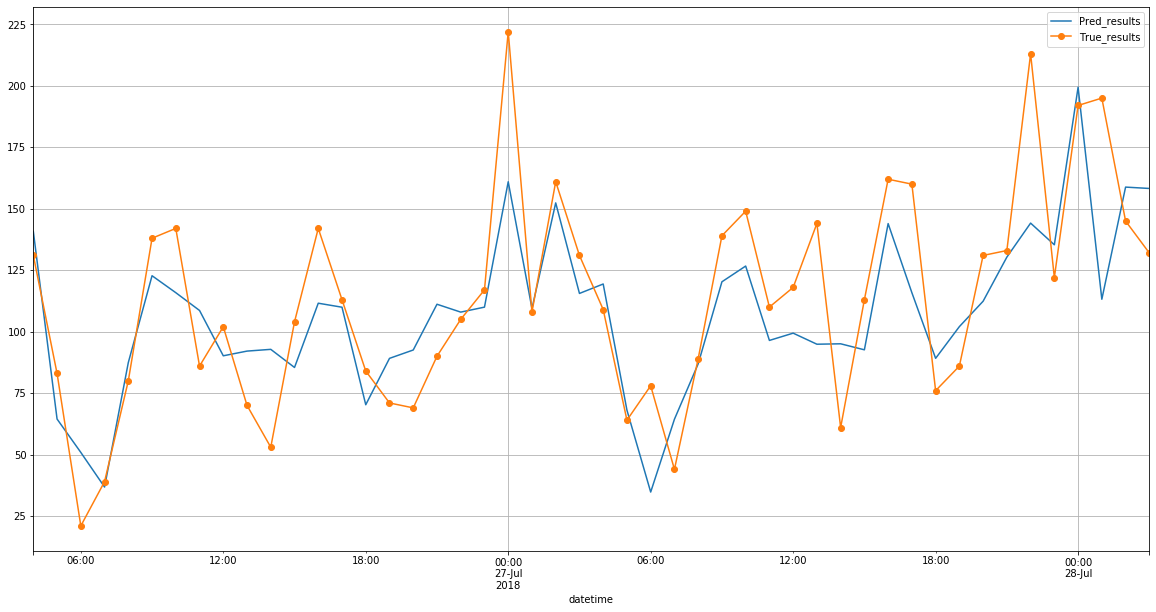

In [ ]:
drawing['Pred_results'].plot(style = '-', grid=True, figsize=(20,10), legend=True)
drawing['True_results'].plot(style = 'o-', grid=True, figsize=(20,10), legend=True)
plt.show()

Лучше всего себя показала модель LGBMRegressor, ее и рекомендуем для использования прогнозирования

## Вывод 

В данном проекте мы рассмотрели как можно с помощью временных рядов предсказывать будущие заказы для такси. Первоначально мы определили, какие закономерности присутствуют в рамках одного месяца, недели и дня, наглядно показав их на графике. После этого, построив 3 модели для обучения, мы смогли ответить на вопрос, какая из моделей лучше всего подойдет для прогнозирования. Все 3 модели успешно справились с заданием, однако лучше всего себя показала модель LGBMRegressor, со значением 45.98. В конце были выведены результаты RMSE для всех моделей.  

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

Группы факторов себе отметил, думаю в любом случае в будущих проектах и на работе понадобится. Все таки хотел уточнить, какие еще можно было использовать модели в данном проекте? слышал про SARIMA, но в данном проекте не решился ее пока использовать. 
Еще раз спасибо большое за все комментарии, для себя отметил много интересного и полезного! если есть возможность, можно ли ли еще где нибудь почитать про временные ряды? Уже обращался к xабру, посмотрел несколько проектов. Все чаще возниккает уверенность, что важнее хороших результатов на моделях является их четкая визуализация.